## NLP Project - Preprocessing and RoBerta

Loading Reddit Data


In [2]:
import numpy as np
import pandas as pd
import re
import json 

import matplotlib as plt
import seaborn as sns 

plt.style.use('ggplot')
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import defaultdict

def load_json(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data 

def load_reddit_data(comments_directory, submissions_directory):
    with open(comments_directory, 'r', encoding='utf-8') as file:
        comment_id_pairs = []
        for i, line in enumerate(file, 1):
            try:
                if i >= 10000000:
                    break
                data = json.loads(line)
                body = data.get('body', '').strip() # Comment text
                link_id = data.get('link_id', '').strip() # Link id
                id = data.get('name', '').strip() # Specific id
                comment_id_pairs.append((body, link_id))
            except json.JSONDecodeError:
                continue  # This is done to avoid missing comments or bad lines
        comment_id_pairs = tuple(comment_id_pairs)
        comments_dict = {id_: text for text, id_ in comment_id_pairs}
        comments_dict = {id_: text for id_, text in comments_dict.items() if text not in ("[deleted]", "[removed]")} # To remove deleted or removed comments
        #print(comments_dict)

    with open(submissions_directory, 'r', encoding='utf-8') as file:
        text_id_pairs = []
        for i, line in enumerate(file, 1):
            try:
                if i >= 10000000:
                    break
                data = json.loads(line)
                title = data.get('title', '').strip() # Submission title
                body = data.get('selftext', '').strip() # Submission text
                id = data.get('name', '').strip() # Specific id
                
                score = data.get('score')
                upvote_ratio = data.get('upvote_ratio')

                
                #length of post
                combined_text = (title + " " + body).strip()
                post_len = len(combined_text)
                text_id_pairs.append((title, body, id, score, post_len, upvote_ratio))
            except json.JSONDecodeError:
                continue # This is done to avoid missing comments or bad lines
        submissions_dict = {
            id: {
                "text": (title + " " + body).strip(),
                "score": score,
                "post_len": post_len,
                "upvote_ratio": upvote_ratio
            }
            for title, body, id, score, post_len, upvote_ratio in text_id_pairs
            if (title + body).strip() not in ("[deleted]", "[removed]")
        }
    grouped = defaultdict(list)
    res = []
    for comment, id_ in comment_id_pairs:
        if id_ in submissions_dict:
            grouped[id_].append(comment)

    banned_phrases = [
        "^^^^automod",
        "welcome to /r/amitheasshole.",
        "your post has been removed",
        "#read this carefully",
        "[removed]",
        "[deleted]"
        ]

    for id_, comments in grouped.items():
        # This removes the copy of each submission because, each submission has an automated comment that starts with the string that is present in the code.
        clean_comments = [c for c in comments  if len(c.strip()) > 0 and not any(phrase in c.lower() for phrase in banned_phrases)] 
        # The following statement is to avoid appending the list with submissions that have no comments at all
        if not clean_comments:
            continue
        combined = (
            submissions_dict[id_]["text"]
            + "[======>]"
            + " ".join(clean_comments)
            + f" [==rq1==>] score={submissions_dict[id_]['score']}, length={submissions_dict[id_]['post_len']}, upvote_ratio={submissions_dict[id_]['upvote_ratio']}"

        )
        res.append(combined)

    res = [post for post in res if not any(p in post.lower() for p in banned_phrases)] # Copy of line clean_comments to ensure the data is filtered completely
    #print(res[4])

    with open("C:/Users/alexb/Desktop/Delft Minor/NLP Project/NLP Git/NLP_project/data/output.json", "w", encoding="utf-8") as f:
        json.dump(res, f, ensure_ascii=False, indent=2)


In [3]:
comments_dir = "C:/Users/alexb/Desktop/Delft Minor/NLP Project/NLP Git/NLP_project/data/amitheasshole_comments.ndjson"
submissions_dir = "C:/Users/alexb/Desktop/Delft Minor/NLP Project/NLP Git/NLP_project/data/amitheasshole_submissions.ndjson"
#reddit_data = load_reddit_data(comments_dir, submissions_dir) # Comment out after running it once

In [44]:
# Loading the [ ['title+body'] =====> [comments] ==rq1==> [upvote_ratio] [post_len] ]
with open("C:/Users/alexb/Desktop/Delft Minor/NLP Project/NLP Git/NLP_project/data/output.json", "r", encoding='utf-8') as f:
    rows = json.load(f)

#loads a submission + all of its comments as a row called 'Raw' 
df = pd.DataFrame({"raw": rows})

regex_seperate_post_comments = r"\s*\[======>\]\s*"
regex_seperate_rq1_values = r"\s*\[==rq1==>\]\s*"
#Creating Dictionary by splitting raw into post, comments columns
df.insert(0, "id", range(1, len(df) + 1))

#splitting into post + comment&data
df[["post", "comments"]] = df["raw"].str.split(regex_seperate_post_comments, n=1, regex=True, expand=True)

#seperating rq1 info from comments
df[["comments", "rq1 data"]] = df["comments"].str.split(regex_seperate_rq1_values, n=1, regex=True, expand=True)
df["rq1 data"] = df["rq1 data"].fillna("")

df["score"] = pd.to_numeric(
    df["rq1 data"].str.extract(r"score=\s*(-?\d+(?:\.\d+)?)")[0],
    errors="coerce"
)

df["post_len"] = (
    pd.to_numeric(
        df["rq1 data"].str.extract(r"length=\s*(\d+)")[0],
        errors="coerce"
    )
    .div(100)
    .round()
    .mul(100)
)

df["upvote_ratio"] = pd.to_numeric(
    df["rq1 data"].str.extract(r"upvote_ratio=([0-9]*\.?[0-9]+)")[0],
    errors="coerce"
)

df["comments"] = df["comments"].fillna("")

#Splitting all comments into a comment list
df["comments_list"] = df["comments"].apply(lambda x: [c.strip() for c in re.split(r"\n\s*\n", x.strip()) if c.strip()])

In [45]:
df.head(10)

,id,raw,post,comments,rq1 data,score,post_len,upvote_ratio,comments_list
0,1,AITA for going off on these boys in my class? ...,AITA for going off on these boys in my class? ...,Nah I don’t think you’re an asshole. Those guy...,"score=9, length=1603, upvote_ratio=0.69",9,1600.0,0.69,[Nah I don’t think you’re an asshole. Those gu...
1,2,AITA for telling something about my husband to...,AITA for telling something about my husband to...,"Thank u, I told him the same but he is over dr...","score=20, length=472, upvote_ratio=0.77",20,500.0,0.77,"[Thank u, I told him the same but he is over d..."
2,3,AITA For Telling My Mom Chores Aren't Fun?!? 1...,AITA For Telling My Mom Chores Aren't Fun?!? 1...,NTA and your mum has ISSUES. She's using the i...,"score=933, length=1608, upvote_ratio=0.94",933,1600.0,0.94,[NTA and your mum has ISSUES. She's using the ...
3,4,AITA for not letting my friends use me anymore...,AITA for not letting my friends use me anymore...,"NTA, friends you make by pleasing whatever the...","score=1, length=1546, upvote_ratio=0.56",1,1500.0,0.56,"[NTA, friends you make by pleasing whatever th..."
4,5,AITA for accepting a McDonald’s from a coworke...,AITA for accepting a McDonald’s from a coworke...,NTA. it’s only a McDonald’s My thoughts exactl...,"score=6, length=2083, upvote_ratio=0.62",6,2100.0,0.62,[NTA. it’s only a McDonald’s My thoughts exact...
5,6,AITA for not letting my daughter have the room...,AITA for not letting my daughter have the room...,Definitely NTA. It’s your house and that’s tha...,"score=122, length=1412, upvote_ratio=0.92",122,1400.0,0.92,[Definitely NTA. It’s your house and that’s th...
6,7,AITA for refusing to make my cousin's wedding ...,AITA for refusing to make my cousin's wedding ...,NTA \n\nBuying a gift would be easier and less...,"score=2046, length=2051, upvote_ratio=0.97",2046,2100.0,0.97,"[NTA, Buying a gift would be easier and less t..."
7,8,AITA for telling my mil it’s not my fault she ...,AITA for telling my mil it’s not my fault she ...,NTA definitely no contact She had it coming bu...,"score=7833, length=1935, upvote_ratio=0.96",7833,1900.0,0.96,[NTA definitely no contact She had it coming b...
8,9,AITA for refusing to pack my boyfriend’s apart...,AITA for refusing to pack my boyfriend’s apart...,"I’d say NTA normally, but it seems like YTA in...","score=120, length=1447, upvote_ratio=0.89",120,1400.0,0.89,"[I’d say NTA normally, but it seems like YTA i..."
9,10,AITA for giving a group of eleven 8-10 year ol...,AITA for giving a group of eleven 8-10 year ol...,NTA. Old people just don't remember how much n...,"score=295, length=1941, upvote_ratio=0.94",295,1900.0,0.94,[NTA. Old people just don't remember how much ...


In [46]:
# Extracting the verdict of the Comment 
asshole_spellings = r"a[\s\-$]*s?[\s\-$]*s?[\s\-$]*h?[\s\-$]*o+[\s\-$]*(?:l+[\s\-$]*e*|e+[\s\-$]*l+)"

# --- YTA ---
regex_spellings_YTA = re.compile(
    rf"\b(?:YTA|you\s*(?:'re|are|re)?\s*(?:an?\s*)?(?:the\s*)?{asshole_spellings}|yes\s+the\s+{asshole_spellings})\b",
    re.IGNORECASE
)

# --- NTA ---
regex_spellings_NTA = re.compile(
    rf"\b(?:NTA|you\s*(?:'re|are|re)?\s*not\s*(?:an?\s*)?(?:the\s*)?{asshole_spellings}|not\s+the\s+{asshole_spellings})\b",
    re.IGNORECASE
)

# --- ESH ---
regex_spelling_esh = re.compile(
    r"\b(?:ESH|everyone\s+sucks\s+here)\b",
    re.IGNORECASE
)

# --- NAH ---
regex_spelling_nah = re.compile(
    rf"\b(?:NAH|no\s+(?:{asshole_spellings}s?|a[\s\-$]*-?holes?)\s+here)\b",
    re.IGNORECASE
)

def extract_verdict(comment):
    text = comment.lower()
    if regex_spellings_YTA.search(text) or regex_spelling_esh.search(text):
        return "YTA"
    if regex_spellings_NTA.search(text) or regex_spelling_nah.search(text):
        return "NTA"  
    else:
        return None


def summarize_verdicts(comment_list):
    counts = {"YTA":0, "NTA":0}
    comment_list = comment_list or []
    n_comments = len(comment_list)

    for comment in (comment_list or []):
        v = extract_verdict(comment)
        if v in counts:
            counts[v] += 1

    n_verdicts = sum(counts.values())
    if n_verdicts == 0:
        return None, 0, 0, counts
    majority = max(counts, key=counts.get)
    polarization = abs(counts["YTA"] - counts["NTA"]) / n_verdicts
    return majority, polarization, n_comments, n_verdicts, counts

df[["majority", "polarization", "num_comments", "num_verdicts", "verdict_counts"]] = (
    df["comments_list"].apply(lambda lst: pd.Series(summarize_verdicts(lst)))
)
sorted_list_num_comments = df.sort_values(by="num_comments", ascending=False).reset_index(drop=True)


In [48]:
sorted_list_num_comments.head(10)

,id,raw,post,comments,rq1 data,score,post_len,upvote_ratio,comments_list,majority,polarization,num_comments,num_verdicts,verdict_counts
0,41770,AITA for my reaction when I learned that my fi...,AITA for my reaction when I learned that my fi...,"NTA. But this isn't really about a dress, is ...","score=32439, length=3402, upvote_ratio=0.95",32439,3400.0,0.95,"[NTA. But this isn't really about a dress, is...",NTA,0.938407,5403,2273,"{'YTA': 70, 'NTA': 2203}"
1,25117,AITA for serving fake meat and pretending it w...,AITA for serving fake meat and pretending it w...,YATA- if it was done the other way around to y...,"score=20387, length=1119, upvote_ratio=0.91",20387,1100.0,0.91,[YATA- if it was done the other way around to ...,YTA,0.493116,5203,1598,"{'YTA': 1193, 'NTA': 405}"
2,34467,AITA for changing the door locks back after my...,AITA for changing the door locks back after my...,Yes YTA \n\nYour wife is allowed to have a saf...,"score=24389, length=5459, upvote_ratio=0.84",24389,5500.0,0.84,"[Yes YTA, Your wife is allowed to have a safe ...",YTA,0.991803,5161,1952,"{'YTA': 1944, 'NTA': 8}"
3,30861,AITA For refusing to pay rent towards my BF's ...,AITA For refusing to pay rent towards my BF's ...,?\n\nIf you were moving in to an apartment tog...,"score=10275, length=3083, upvote_ratio=0.81",10275,3100.0,0.81,"[?, If you were moving in to an apartment toge...",YTA,0.825243,4954,1854,"{'YTA': 1692, 'NTA': 162}"
4,3047,AITA for leaving a couples trip in the middle ...,AITA for leaving a couples trip in the middle ...,"Soft Yta. what she said was relatively shitty,...","score=8974, length=3682, upvote_ratio=0.91",8974,3700.0,0.91,[Soft Yta. what she said was relatively shitty...,YTA,0.668449,4875,1309,"{'YTA': 1092, 'NTA': 217}"
5,31510,AITA for making my daughter share her presents...,AITA for making my daughter share her presents...,YTA. Everything you’re doing to build closenes...,"score=17164, length=2988, upvote_ratio=0.8",17164,3000.0,0.80,[YTA. Everything you’re doing to build closene...,YTA,0.983516,4868,1820,"{'YTA': 1805, 'NTA': 15}"
6,34455,AITA for telling my daughter I won’t be paying...,AITA for telling my daughter I won’t be paying...,YTA she's an adult. Stop being manipulative. Y...,"score=16904, length=3109, upvote_ratio=0.91",16904,3100.0,0.91,[YTA she's an adult. Stop being manipulative. ...,YTA,0.398305,4822,1416,"{'YTA': 990, 'NTA': 426}"
7,44232,AITA for not letting my daughter use her colle...,AITA for not letting my daughter use her colle...,INFO\n\n&gt; We had just planned on splitting ...,"score=19389, length=3069, upvote_ratio=0.92",19389,3100.0,0.92,"[INFO, &gt; We had just planned on splitting i...",YTA,0.096999,4041,1433,"{'YTA': 786, 'NTA': 647}"
8,30736,AITA for telling daughter I'm disappointed in ...,AITA for telling daughter I'm disappointed in ...,NTA.. I think you handled it perfectly and yo...,"score=18412, length=2832, upvote_ratio=0.95",18412,2800.0,0.95,[NTA.. I think you handled it perfectly and y...,NTA,0.095652,3991,1150,"{'YTA': 520, 'NTA': 630}"
9,39780,AITA for refusing to split rent with my boyfri...,AITA for refusing to split rent with my boyfri...,Yeah YTA. That’s so weird that you wouldn’t me...,"score=22947, length=1825, upvote_ratio=0.95",22947,1800.0,0.95,[Yeah YTA. That’s so weird that you wouldn’t m...,NTA,0.354481,3950,1261,"{'YTA': 407, 'NTA': 854}"


In [8]:

from nltk.sentiment import SentimentIntensityAnalyzer 
from tqdm.notebook import tqdm # tracks loop progress through a bar

sia = SentimentIntensityAnalyzer() #initalize and call it 

sia #object is created

# run loop for scores
results = {}
for i, row in tqdm(sorted_list_num_comments.iterrows(), total=len(sorted_list_num_comments)):
    text = row['post']
    myid = row['id']
    results[myid] = sia.polarity_scores(text)

vader_results_posts = pd.DataFrame(results).T # T transposes the dictionary
vader_results_posts = vader_results_posts.reset_index().rename(columns={'index': 'id'})
vader_results_posts_soretd_num_comments = vader_results_posts.merge(sorted_list_num_comments, how='left')
vader_results_posts_soretd_num_comments

  0%|          | 0/47872 [00:00<?, ?it/s]

,id,neg,neu,pos,compound,raw,post,comments,rq1 data,score,post_len,upvote_ratio,comments_list,majority,polarization,num_comments,num_verdicts,verdict_counts
0,41770,0.108,0.804,0.088,-0.8743,AITA for my reaction when I learned that my fi...,AITA for my reaction when I learned that my fi...,"NTA. But this isn't really about a dress, is ...","score=32439, length=3402, upvote_ratio=0.95",32439,3500.0,0.95,"[NTA. But this isn't really about a dress, is...",NTA,0.938407,5403,2273,"{'YTA': 70, 'NTA': 2203}"
1,25117,0.069,0.846,0.085,0.5819,AITA for serving fake meat and pretending it w...,AITA for serving fake meat and pretending it w...,YATA- if it was done the other way around to y...,"score=20387, length=1119, upvote_ratio=0.91",20387,1000.0,0.91,[YATA- if it was done the other way around to ...,YTA,0.493116,5203,1598,"{'YTA': 1193, 'NTA': 405}"
2,34467,0.057,0.849,0.094,0.9834,AITA for changing the door locks back after my...,AITA for changing the door locks back after my...,Yes YTA \n\nYour wife is allowed to have a saf...,"score=24389, length=5459, upvote_ratio=0.84",24389,5500.0,0.84,"[Yes YTA, Your wife is allowed to have a safe ...",YTA,0.991803,5161,1952,"{'YTA': 1944, 'NTA': 8}"
3,30861,0.087,0.798,0.115,0.9688,AITA For refusing to pay rent towards my BF's ...,AITA For refusing to pay rent towards my BF's ...,?\n\nIf you were moving in to an apartment tog...,"score=10275, length=3083, upvote_ratio=0.81",10275,3000.0,0.81,"[?, If you were moving in to an apartment toge...",YTA,0.825243,4954,1854,"{'YTA': 1692, 'NTA': 162}"
4,3047,0.088,0.795,0.117,0.9091,AITA for leaving a couples trip in the middle ...,AITA for leaving a couples trip in the middle ...,"Soft Yta. what she said was relatively shitty,...","score=8974, length=3682, upvote_ratio=0.91",8974,3500.0,0.91,[Soft Yta. what she said was relatively shitty...,YTA,0.668449,4875,1309,"{'YTA': 1092, 'NTA': 217}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47867,47735,0.089,0.822,0.090,-0.4403,AITA for being rude to my husband for not goin...,AITA for being rude to my husband for not goin...,"As someone with adhd, I completely understand ...","score=1, length=3052, upvote_ratio=0.54",1,3000.0,0.54,"[As someone with adhd, I completely understand...",None,0.000000,0,"{'YTA': 0, 'NTA': 0}",NaN
47868,19948,0.074,0.787,0.139,0.9892,AITA for thinking my friend was talking behind...,AITA for thinking my friend was talking behind...,Sorry but what is going on? \nPlease use para...,"score=0, length=2529, upvote_ratio=0.31",0,2500.0,0.31,[Sorry but what is going on? \nPlease use par...,None,0.000000,0,"{'YTA': 0, 'NTA': 0}",NaN
47869,22224,0.092,0.805,0.103,0.3008,AITA for refusing to help my partner? *PM: Par...,AITA for refusing to help my partner? *PM: Par...,"They needs to stop saying the saying ""that sou...","score=0, length=1406, upvote_ratio=0.45",0,1500.0,0.45,"[They needs to stop saying the saying ""that so...",None,0.000000,0,"{'YTA': 0, 'NTA': 0}",NaN
47870,40715,0.035,0.781,0.185,0.9510,"WIBTA if i went to jacksonville, florida? Me (...","WIBTA if i went to jacksonville, florida? Me (...","I think you would be breaking the ""law of girl...","score=0, length=556, upvote_ratio=0.4",0,500.0,0.40,"[I think you would be breaking the ""law of gir...",None,0.000000,0,"{'YTA': 0, 'NTA': 0}",NaN


In [43]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# --- 1) Take a 20% sample (stratified-ish by random state) ---
test_df = sorted_list_num_comments.sample(frac=0.20, random_state=42).reset_index(drop=True)

# --- 2) Prepare data from the sample only ---
ids   = test_df["id"].tolist()
texts = test_df["post"].astype(str).tolist()

batch_size = 64
max_length = 256

MODEL = "cardiffnlp/twitter-roberta-base-sentiment" 
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

all_ids, all_probs = [], []

for i in tqdm(range(0, len(texts), batch_size), desc="RoBERTa scoring (20% sample, batched)"):
    batch_texts = texts[i:i+batch_size]
    enc = tokenizer(
        batch_texts,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=max_length
    ).to(device)

    with torch.no_grad():
        logits = model(**enc).logits

    probs = softmax(logits.cpu().numpy(), axis=1)

    neg_prob = probs[:, 0]   # negative
    neu_prob = probs[:, 1]   # neutral
    pos_prob = probs[:, 2]   # positive

    compound = pos_prob - neg_prob 

    all_ids.extend(ids[i:i+batch_size])
    all_probs.extend(hate_prob.tolist())

# --- 4) Build results for the sample and merge (like VADER flow) ---
roberta_results_posts_sorted_num_comments = pd.DataFrame({"id": all_ids, "sent_compound": all_probs})
roberta_results_posts_sorted_num_comments = sorted_list_num_comments.merge(
    test_df, how="left", on="id"
)

roberta_results_posts_sorted_num_comments.head()



RoBERTa scoring (20% sample, batched):   0%|          | 0/150 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [51]:
roberta_results_posts_sorted_num_comments["verdict_binary"] = roberta_results_posts_sorted_num_comments["majority"].map({"YTA": 1, "NTA": 0})

In [52]:
roberta_results_posts_sorted_num_comments.loc[:,["score","post_len","upvote_ratio","verdict_binary"]] 
df_clean_roberta = roberta_results_posts_sorted_num_comments.dropna(subset=["verdict_binary"]).copy()
df_clean_roberta.head()

,id,hate_prob,raw,post,comments,rq1 data,score,post_len,upvote_ratio,comments_list,majority,polarization,num_comments,num_verdicts,verdict_counts,verdict_binary
0,6685,0.021075,AITA for not letting my bf to meet a mutual fr...,AITA for not letting my bf to meet a mutual fr...,Esh you all suck and meed to grow up i think o...,"score=1, length=1240, upvote_ratio=0.57",1,1000.0,0.57,[Esh you all suck and meed to grow up i think ...,YTA,1.00,1,1,"{'YTA': 1, 'NTA': 0}",1.0
1,12651,0.704453,AITA for convincing my best friend to kick out...,AITA for convincing my best friend to kick out...,INFO. What were you uncomfortable about? Were ...,"score=0, length=1854, upvote_ratio=0.47",0,2000.0,0.47,[INFO. What were you uncomfortable about? Were...,YTA,0.75,29,16,"{'YTA': 14, 'NTA': 2}",1.0
2,20062,0.091826,AITA for refusing to turn my account private? ...,AITA for refusing to turn my account private? ...,Perhaps make any videos or photos that include...,"score=1, length=3016, upvote_ratio=0.56",1,3000.0,0.56,[Perhaps make any videos or photos that includ...,NTA,1.00,6,1,"{'YTA': 0, 'NTA': 1}",0.0
3,43993,0.025146,AITA For Wanting To Go To A Wedding Without My...,AITA For Wanting To Go To A Wedding Without My...,I feel like the right thing to do here would b...,"score=9, length=3059, upvote_ratio=0.74",9,3000.0,0.74,[I feel like the right thing to do here would ...,YTA,0.00,15,6,"{'YTA': 3, 'NTA': 3}",1.0
4,39662,0.017512,WIBTA- For telling my parents to stop making m...,WIBTA- For telling my parents to stop making m...,YWNBTA. It's your labor - only you get to deci...,"score=465, length=1807, upvote_ratio=0.95",465,2000.0,0.95,[YWNBTA. It's your labor - only you get to dec...,NTA,1.00,65,26,"{'YTA': 0, 'NTA': 26}",0.0


# Data Explorationa and Plots

## Exploration

In [53]:
vader_results_posts_soretd_num_comments["verdict_binary"] = vader_results_posts_soretd_num_comments["majority"].map({"YTA": 1, "NTA": 0})

In [54]:
vader_results_posts_soretd_num_comments.loc[:,["score","post_len","upvote_ratio","verdict_binary"]] 
df_clean_vader = vader_results_posts_soretd_num_comments.dropna(subset=["verdict_binary"]).copy()
df_clean_vader.head()

,id,neg,neu,pos,compound,raw,post,comments,rq1 data,score,post_len,upvote_ratio,comments_list,majority,polarization,num_comments,num_verdicts,verdict_counts,verdict_binary
0,41770,0.108,0.804,0.088,-0.8743,AITA for my reaction when I learned that my fi...,AITA for my reaction when I learned that my fi...,"NTA. But this isn't really about a dress, is ...","score=32439, length=3402, upvote_ratio=0.95",32439,3500.0,0.95,"[NTA. But this isn't really about a dress, is...",NTA,0.938407,5403,2273,"{'YTA': 70, 'NTA': 2203}",0.0
1,25117,0.069,0.846,0.085,0.5819,AITA for serving fake meat and pretending it w...,AITA for serving fake meat and pretending it w...,YATA- if it was done the other way around to y...,"score=20387, length=1119, upvote_ratio=0.91",20387,1000.0,0.91,[YATA- if it was done the other way around to ...,YTA,0.493116,5203,1598,"{'YTA': 1193, 'NTA': 405}",1.0
2,34467,0.057,0.849,0.094,0.9834,AITA for changing the door locks back after my...,AITA for changing the door locks back after my...,Yes YTA \n\nYour wife is allowed to have a saf...,"score=24389, length=5459, upvote_ratio=0.84",24389,5500.0,0.84,"[Yes YTA, Your wife is allowed to have a safe ...",YTA,0.991803,5161,1952,"{'YTA': 1944, 'NTA': 8}",1.0
3,30861,0.087,0.798,0.115,0.9688,AITA For refusing to pay rent towards my BF's ...,AITA For refusing to pay rent towards my BF's ...,?\n\nIf you were moving in to an apartment tog...,"score=10275, length=3083, upvote_ratio=0.81",10275,3000.0,0.81,"[?, If you were moving in to an apartment toge...",YTA,0.825243,4954,1854,"{'YTA': 1692, 'NTA': 162}",1.0
4,3047,0.088,0.795,0.117,0.9091,AITA for leaving a couples trip in the middle ...,AITA for leaving a couples trip in the middle ...,"Soft Yta. what she said was relatively shitty,...","score=8974, length=3682, upvote_ratio=0.91",8974,3500.0,0.91,[Soft Yta. what she said was relatively shitty...,YTA,0.668449,4875,1309,"{'YTA': 1092, 'NTA': 217}",1.0


### Logistic Regression on post length vs YTA verdict

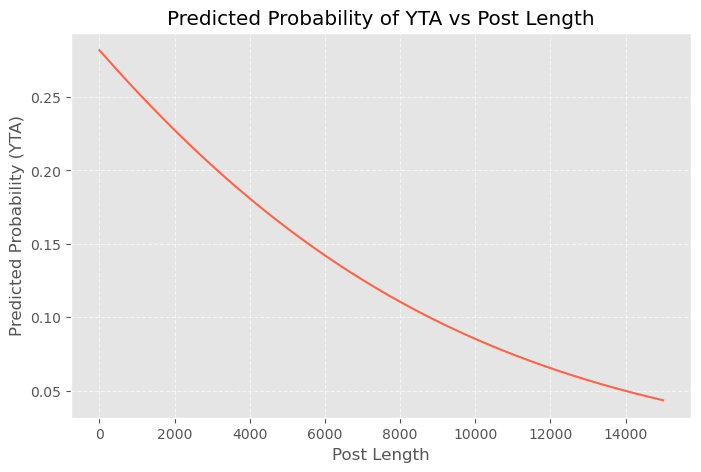

C:\Users\alexb\AppData\Local\Temp\ipykernel_10720\2706411668.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="coolwarm")


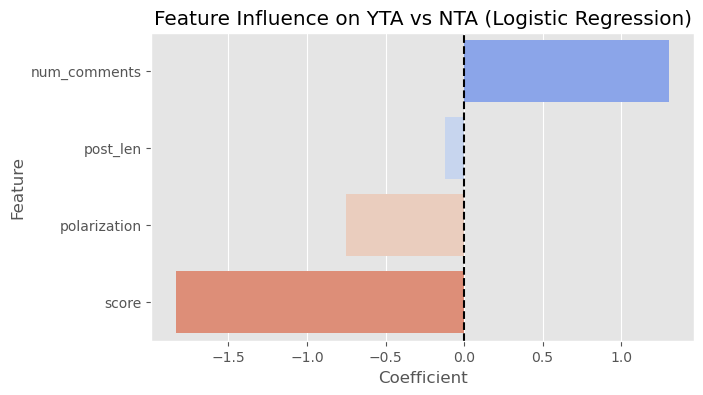

Accuracy: 0.7797383696475141

Confusion matrix:
 [[32620  2122]
 [ 8351  4455]]


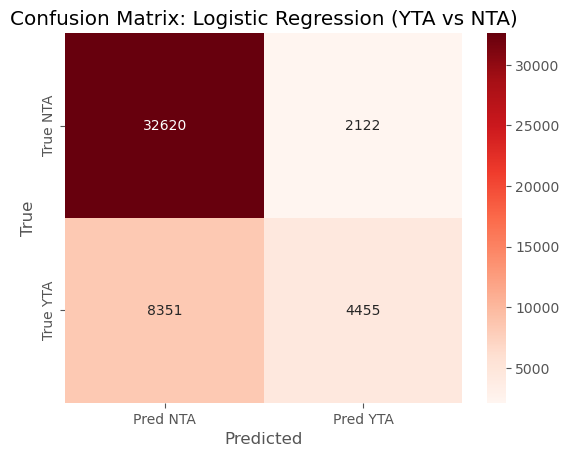

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix


features = ["post_len", "score", "polarization", "num_comments"]
X = df_clean_vader[features]
y = df_clean_vader["verdict_binary"]
log_reg_pipeline.fit(X, y)

# Range of post lengths
post_len_range = np.linspace(df_clean_vader["post_len"].min(), df_clean_vader["post_len"].max(), 500)

# Build prediction DataFrame (keep others at mean)
X_pred = pd.DataFrame({
    "post_len": post_len_range,
    "score": df_clean_vader["score"].mean(),
    "polarization": df_clean_vader["polarization"].mean(),
    "num_comments": df_clean_vader["num_comments"].mean(),
   
})

# Predict probability of YTA
y_pred_prob = log_reg_pipeline.predict_proba(X_pred)[:, 1]

# Plot
plt.figure(figsize=(8,5))
plt.plot(post_len_range, y_pred_prob, color="tomato")
plt.xlabel("Post Length")
plt.ylabel("Predicted Probability (YTA)")
plt.title("Predicted Probability of YTA vs Post Length")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()



coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": log_reg_pipeline.named_steps["model"].coef_[0]
}).sort_values("Coefficient", ascending=False)

plt.figure(figsize=(7,4))
sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="coolwarm")
plt.title("Feature Influence on YTA vs NTA (Logistic Regression)")
plt.axvline(0, color="black", linestyle="--")
plt.show()



y_pred = log_reg_pipeline.predict(X)
print("Accuracy:", accuracy_score(y, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y, y_pred))




cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=["Pred NTA", "Pred YTA"],
            yticklabels=["True NTA", "True YTA"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: Logistic Regression (YTA vs NTA)")
plt.show()


## LR with Vader


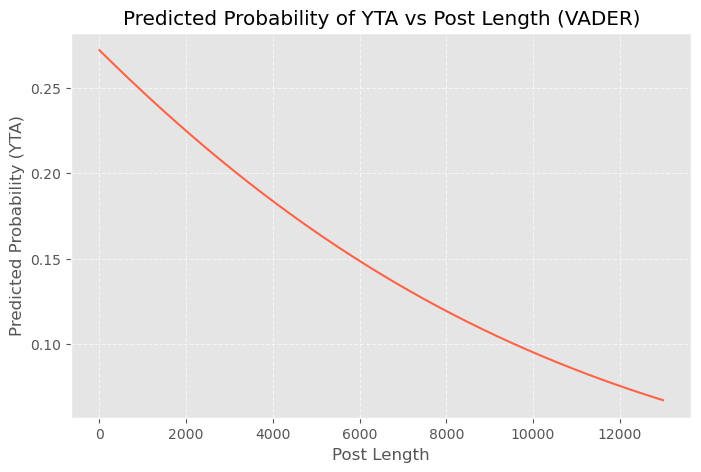

C:\Users\alexb\AppData\Local\Temp\ipykernel_4024\3222389491.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="coolwarm")


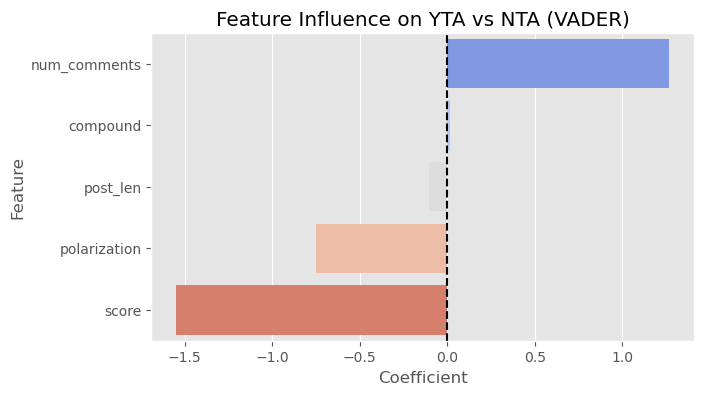

Accuracy: 0.7884332281808623

Confusion matri Vader:
 [[6676  350]
 [1662  822]]


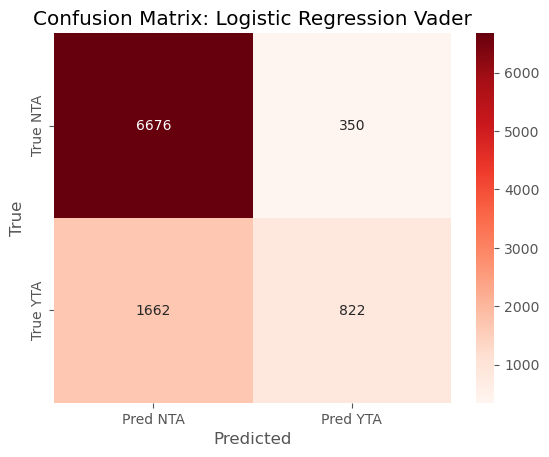

In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# ---- take 20% sample for fair comparison ----
dfv = df_clean_vader.sample(frac=0.20, random_state=42).reset_index(drop=True)

features = ["post_len","compound" ,"score", "polarization", "num_comments"]
# ensure numeric & drop missing rows for modeling
dfv[features + ["verdict_binary"]] = dfv[features + ["verdict_binary"]].apply(pd.to_numeric, errors="coerce")
dfv = dfv.dropna(subset=features + ["verdict_binary"])

X = dfv[features]
y = dfv["verdict_binary"]

# pipeline
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])
log_reg_pipeline.fit(X, y)

# ---- partial dependence: vary post_len, hold others at mean ----
post_len_range = np.linspace(dfv["post_len"].min(), dfv["post_len"].max(), 500)
means = dfv[features].mean(numeric_only=True)

X_pred = pd.DataFrame({
    "post_len": post_len_range,
    "score": np.full_like(post_len_range, means["score"], dtype=float),
    "compound": np.full_like(post_len_range, means["compound"],dtype=float),
    "polarization": np.full_like(post_len_range, means["polarization"], dtype=float),
    "num_comments": np.full_like(post_len_range, means["num_comments"], dtype=float),
})[features]

# Predict probability of YTA
y_pred_prob = log_reg_pipeline.predict_proba(X_pred)[:, 1]

# Plot P(YTA) vs post_len
plt.figure(figsize=(8,5))
plt.plot(post_len_range, y_pred_prob, color="tomato")
plt.xlabel("Post Length"); plt.ylabel("Predicted Probability (YTA)")
plt.title("Predicted Probability of YTA vs Post Length (VADER)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Coefficients
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": log_reg_pipeline.named_steps["model"].coef_[0]
}).sort_values("Coefficient", ascending=False)

plt.figure(figsize=(7,4))
sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="coolwarm")
plt.title("Feature Influence on YTA vs NTA (VADER)")
plt.axvline(0, color="black", linestyle="--")
plt.show()

# Metrics on the 20% sample
y_pred = log_reg_pipeline.predict(X)
print("Accuracy:", accuracy_score(y, y_pred))
cm = confusion_matrix(y, y_pred)
print("\nConfusion matri Vader:\n", cm)

sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=["Pred NTA", "Pred YTA"],
            yticklabels=["True NTA", "True YTA"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix: Logistic Regression Vader")
plt.show()


### LR with Roberta
- using compound and upvote to try improve regression

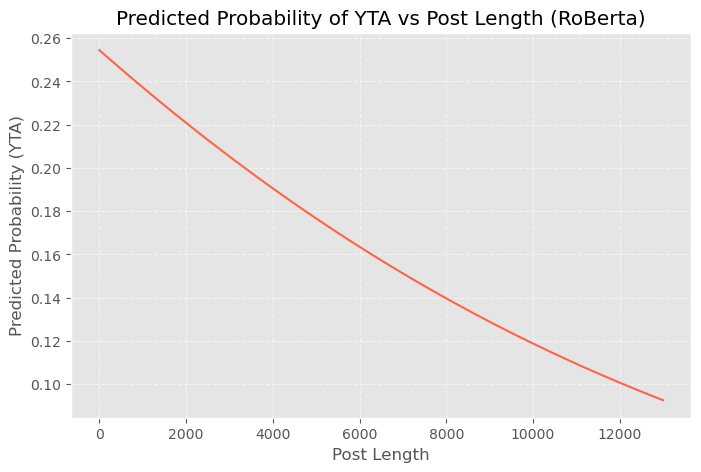

C:\Users\alexb\AppData\Local\Temp\ipykernel_4024\3014153941.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="coolwarm")


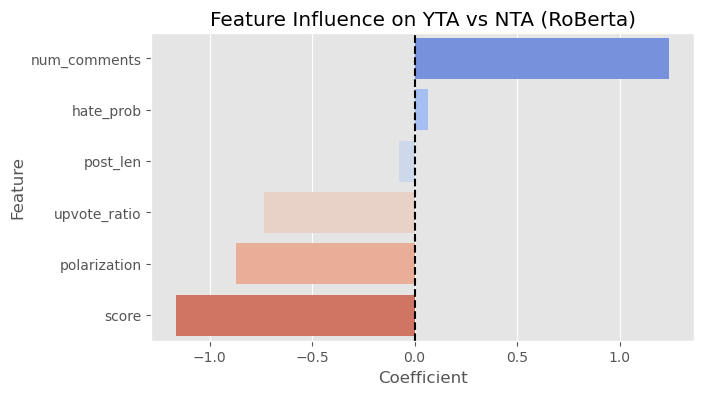

Accuracy: 0.7856166544001683

Confusion matrix:
 [[6395  530]
 [1509 1077]]


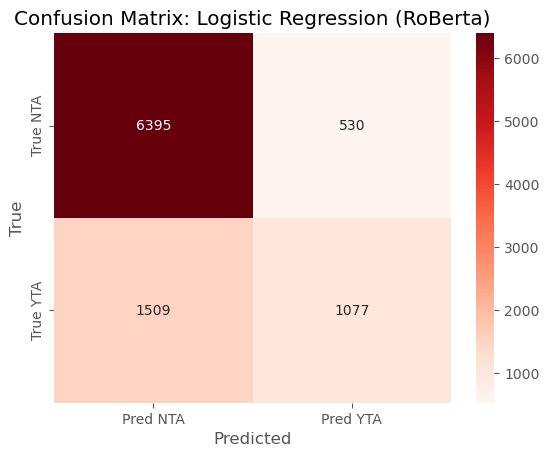

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

# --- features & data ---
features = ["post_len", "score", "upvote_ratio", "polarization", "num_comments", "hate_prob"]

dfm = df_clean_roberta.copy()
dfm[features] = dfm[features].apply(pd.to_numeric, errors="coerce")
dfm = dfm.dropna(subset=features + ["verdict_binary"]).reset_index(drop=True)

X = dfm[features]
y = dfm["verdict_binary"]

# --- pipeline ---
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])
log_reg_pipeline.fit(X, y)

# --- partial dependence: vary post_len, hold others at mean ---
post_len_range = np.linspace(dfm["post_len"].min(), dfm["post_len"].max(), 500)
means = dfm[features].mean(numeric_only=True)

X_pred = pd.DataFrame({
    "post_len": post_len_range,
    "score": np.full_like(post_len_range, means["score"], dtype=float),
    "upvote_ratio": np.full_like(post_len_range, means["upvote_ratio"], dtype=float),
    "polarization": np.full_like(post_len_range, means["polarization"], dtype=float),
    "num_comments": np.full_like(post_len_range, means["num_comments"], dtype=float),
    "hate_prob": np.full_like(post_len_range, means["hate_prob"], dtype=float),
})[features]  # enforce exact column order

# --- plot P(YTA) vs post_len ---
y_pred_prob = log_reg_pipeline.predict_proba(X_pred)[:, 1]
plt.figure(figsize=(8,5))
plt.plot(post_len_range, y_pred_prob, color="tomato")
plt.xlabel("Post Length")
plt.ylabel("Predicted Probability (YTA)")
plt.title("Predicted Probability of YTA vs Post Length (RoBerta)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# --- coefficients ---
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": log_reg_pipeline.named_steps["model"].coef_[0]
}).sort_values("Coefficient", ascending=False)

plt.figure(figsize=(7,4))
sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="coolwarm")
plt.title("Feature Influence on YTA vs NTA (RoBerta)")
plt.axvline(0, color="black", linestyle="--")
plt.show()

# --- in-sample metrics ---
y_pred = log_reg_pipeline.predict(X)
print("Accuracy:", accuracy_score(y, y_pred))
cm = confusion_matrix(y, y_pred)
print("\nConfusion matrix:\n", cm)

sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=["Pred NTA", "Pred YTA"],
            yticklabels=["True NTA", "True YTA"])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix: Logistic Regression (RoBerta)")
plt.show()


C:\Users\alexb\AppData\Local\Temp\ipykernel_10720\2681359107.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="coolwarm")


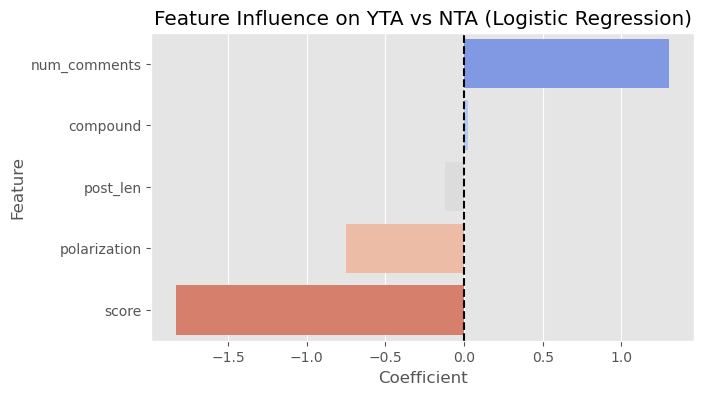

In [59]:
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": log_reg_pipeline.named_steps["model"].coef_[0]
}).sort_values("Coefficient", ascending=False)

plt.figure(figsize=(7,4))
sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="coolwarm")
plt.title("Feature Influence on YTA vs NTA (Logistic Regression)")
plt.axvline(0, color="black", linestyle="--")
plt.show()

## Plot 

Post Length vs Upvote Ratio

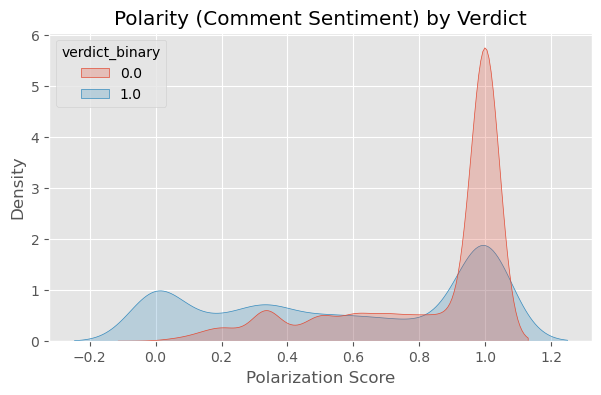

In [69]:
plt.figure(figsize=(7,4))
sns.kdeplot(data=dfv, x="polarization", hue="verdict_binary", fill=True, common_norm=False)
plt.title("Polarity (Comment Sentiment) by Verdict")
plt.xlabel("Polarization Score")
plt.xticks()
plt.show()





Post Length vs Score 

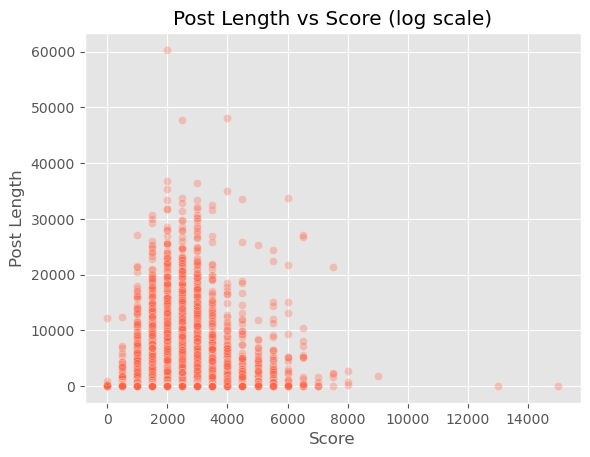

In [25]:

import matplotlib_inline
import matplotlib.pyplot as plt
sns.scatterplot(x="post_len", y="score", data=df, alpha=0.3, color="tomato")
plt.xlabel("Score")
plt.ylabel("Post Length")
plt.title("Post Length vs Score (log scale)")
plt.show()

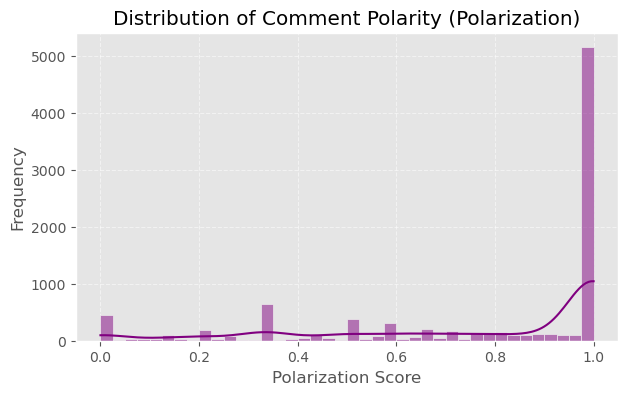

In [64]:
plt.figure(figsize=(7,4))
sns.histplot(dfv["polarization"], kde=True, bins=40, color="purple")
plt.title("Distribution of Comment Polarity (Polarization)")
plt.xlabel("Polarization Score")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

<Axes: xlabel='post_len', ylabel='verdict_binary'>

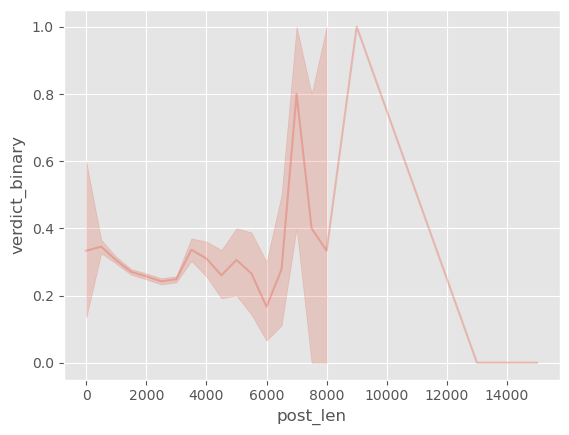

In [41]:
sns.lineplot(x="post_len", y="verdict_binary", data=vader_results_posts_soretd_num_comments, alpha=0.3)

C:\Users\alexb\AppData\Local\Temp\ipykernel_4024\2189474590.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="coolwarm")


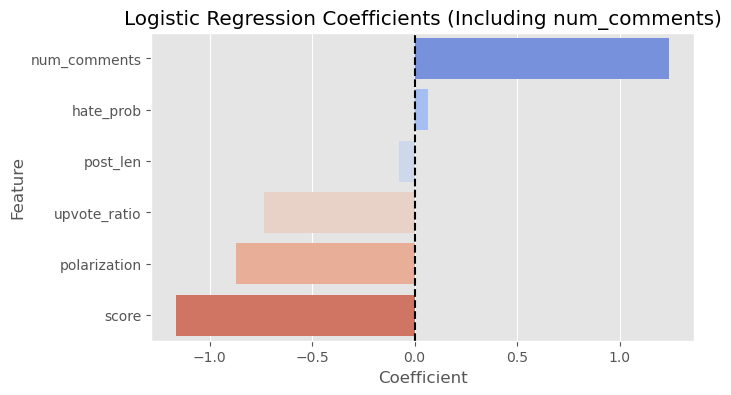

C:\Users\alexb\AppData\Local\Temp\ipykernel_4024\2189474590.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="coolwarm")


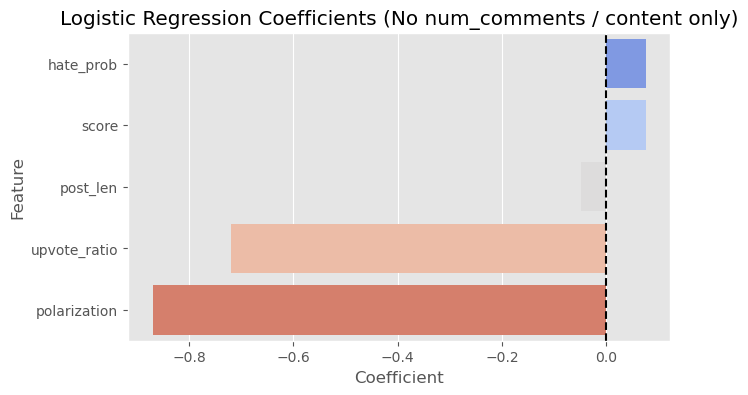

In [ ]:
# MODEL A: with num_comments 2
features_a = ["post_len", "score", "upvote_ratio", "polarization", "num_comments", "hate_prob"]

# MODEL B: without num_comments (content only)
features_b = ["post_len", "score", "upvote_ratio", "polarization", "hate_prob"]

def train_and_plot(features, title_suffix):
    X = dfm[features]
    y = dfm["verdict_binary"]

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000))
    ])
    pipe.fit(X, y)

    coef_df = pd.DataFrame({
        "Feature": features,
        "Coefficient": pipe.named_steps["model"].coef_[0]
    }).sort_values("Coefficient", ascending=False)

    plt.figure(figsize=(7,4))
    sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="coolwarm")
    plt.title(f"Logistic Regression Coefficients {title_suffix}")
    plt.axvline(0, color='black', linestyle='--')
    plt.show()

train_and_plot(features_a, "(Including num_comments)")
train_and_plot(features_b, "(No num_comments / content only)")


C:\Users\alexb\AppData\Local\Temp\ipykernel_4024\1239590062.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="coolwarm")


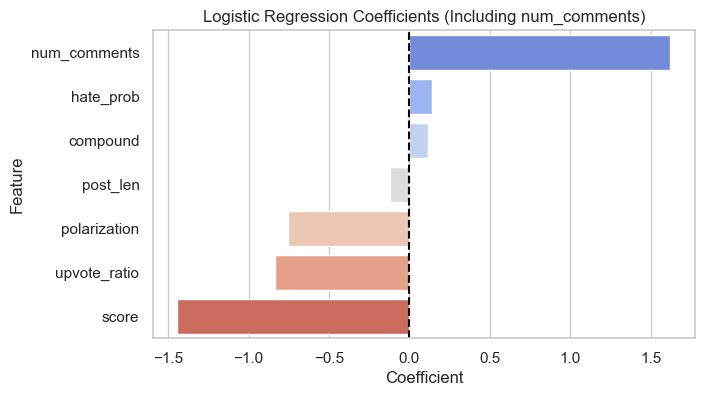

C:\Users\alexb\AppData\Local\Temp\ipykernel_4024\1239590062.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="coolwarm")


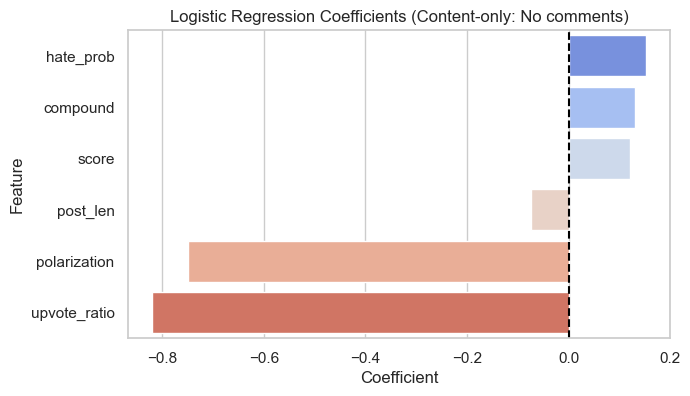

In [ ]:
key = "id"

cols_v = ["id","post_len","score","upvote_ratio","polarization","num_comments",
          "compound","verdict_binary"]
cols_m = ["id","hate_prob"]

dfc = (dfv[cols_v]
       .merge(dfm[cols_m], on=key, how="inner")
       .copy())


features_a = ["post_len","score","upvote_ratio","polarization","num_comments","compound","hate_prob"]
features_b = ["post_len","score","upvote_ratio","polarization","compound","hate_prob"]

dfc[features_a + ["verdict_binary"]] = dfc[features_a + ["verdict_binary"]].apply(
    pd.to_numeric, errors="coerce"
)
dfc = dfc.dropna(subset=features_a + ["verdict_binary"])

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def train_and_plot(df, features, title_suffix):
    X = df[features]
    y = df["verdict_binary"]

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000))
    ]).fit(X, y)

    coef_df = (pd.DataFrame({
        "Feature": features,
        "Coefficient": pipe.named_steps["model"].coef_[0]
    }).sort_values("Coefficient", ascending=False))

    plt.figure(figsize=(7,4))
    sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="coolwarm")
    plt.title(f"Logistic Regression Coefficients {title_suffix}")
    plt.axvline(0, color='black', linestyle='--')
    plt.show()

train_and_plot(dfc, features_a, "(Including num_comments)")
train_and_plot(dfc, features_b, "(Content-only: No comments)")



In [97]:
# ---- Feature label mapping (nice names for plotting) ----
nice_names = {
    "post_len": "Post Length (chars)",
    "score": "Score (Upvotes)",
    "upvote_ratio": "Upvote Ratio",
    "polarization": "Comment Polarity",
    "compound": "Sentiment (Compound)",
    "num_comments": "Number of Comments",
    "hate_prob": "Hate Speech Probability"
}

def train_and_plot(df, features, title_suffix):
    X = df[features]
    y = df["verdict_binary"]

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000))
    ]).fit(X, y)

    # Map features to nicer names here
    coef_df = pd.DataFrame({
        "Feature": [nice_names.get(f, f) for f in features],
        "Coefficient": pipe.named_steps["model"].coef_[0]
    }).sort_values("Coefficient", ascending=False)

    plt.figure(figsize=(7,4))
    sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="coolwarm")
    plt.title(f"Logistic Regression Coefficients {title_suffix}")
    plt.axvline(0, color='black', linestyle='--')

    plt.xlabel("Coefficient")
    plt.ylabel("Feature")
    plt.show()


C:\Users\alexb\AppData\Local\Temp\ipykernel_4024\987976681.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="coolwarm")


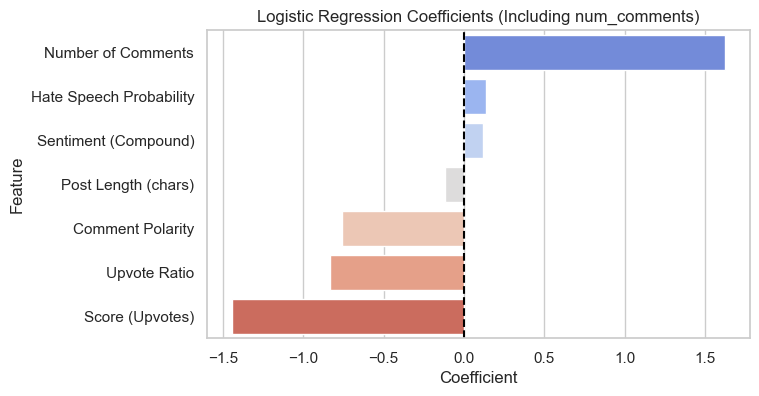

C:\Users\alexb\AppData\Local\Temp\ipykernel_4024\987976681.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="coolwarm")


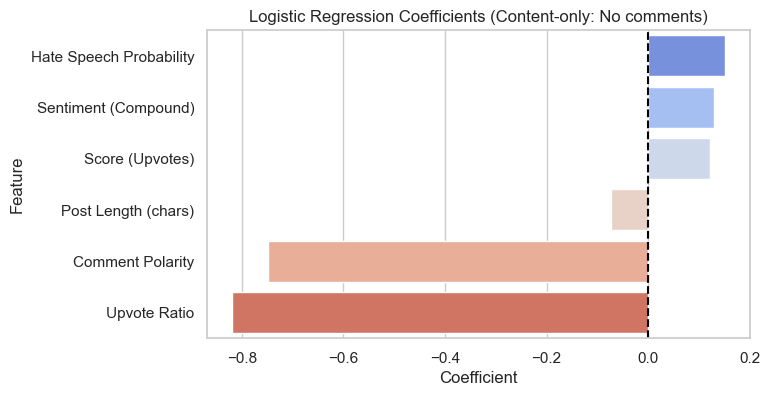

In [98]:
train_and_plot(dfc, features_a, "(Including num_comments)")
train_and_plot(dfc, features_b, "(Content-only: No comments)")
